In [246]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt
#import pyfolio as pf

import backtrader.plot.formatters as fmt
import backtrader.plot.locator as loc
import numpy as np
import matplotlib.pyplot as plt
import MyUtils 
import CurrencyAdjuster

In [424]:
class BenchmarkStrat(bt.Strategy):
    params = (('monthlyinvestment', 1000), )

    def __init__(self):
        self.stratname = 'Benchmark'
        self.smaVTSMX = bt.indicators.SimpleMovingAverage(self.datas[3], period=8)
        self.invested=False
        self.lastmonth = None
    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None

    def next(self):         
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("BEN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("BEN: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            portfolio_value = self.broker.get_value()
            self.order_target_value(self.dnames['Benchmark'], target=portfolio_value - 4000.0)
            self.lastmonth=dt.month


class TimingSMAMixed(bt.Strategy):
    params = (('monthlyinvestment', 1000), )

    def __init__(self):
        self.smaVTSMX = bt.indicators.SimpleMovingAverage(self.datas[3], period=8)
        self.outofmarket = True
        self.stratname = 'SMAMixed'
        self.invested=False
        self.lastmonth=None

    def notify_order(self, order):
        if order.status == order.Completed:
            pass

        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None
        
    #def prenext(self):
    #    if len(self)==1:
    #        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
    #        self.order_target_percent(self.dnames['VBMFX'], target=0.19) 
    #        self.order_target_percent(self.dnames['VTSMX'], target=0.79)
    #        self.outofmarket = False
    #        print("MIX %s  - Initial entering into market" % dt.date())
    
    def next(self):
            
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        #print("%04d  - %s - %s " % (len(self), dt.isoformat() , lastdt.isoformat()))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]

        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("MIX: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
       
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("MIX: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            lastclose = self.datas[3].close[0]
            smaval = self.smaVTSMX[0]
            equity_value = self.broker.get_value([self.dnames['VTSMX']])
            bond_value = self.broker.get_value([self.dnames['VBMFX']])
            portfolio_value = self.broker.get_value()
            trading = False
            if smaval > lastclose and self.outofmarket==False:
                self.order_target_value(self.dnames['VTSMX'], target=0.0)
                self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0) 
                self.outofmarket = True
                trading = True
            if smaval < lastclose and self.outofmarket==True:
                self.order_target_percent(self.dnames['VBMFX'], target=0.19) 
                self.order_target_percent(self.dnames['VTSMX'], target=0.79)
                self.outofmarket = False
                trading = True
            if trading:
                print('MIX %04d - %s - SMA: %.2f; C: %.2f; EqVal: %.2f; BdVal: %.2f; Cash: %.2f; PF: %.2f' %
                    (len(self), dt.date(), smaval, lastclose, equity_value, bond_value, portfolio_value-equity_value-bond_value, portfolio_value ))
                if self.outofmarket:
                    print("Leaving market on %s" % dt.date())
                else:
                    print("Entering market on %s" % dt.date())
            if trading==False: #We are not trading, just rebalance in case we are in the market:
                if self.outofmarket==False:
                    self.order_target_percent(self.dnames['VBMFX'], target=0.19) 
                    self.order_target_percent(self.dnames['VTSMX'], target=0.79)
                else:
                    self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0) 
            self.lastmonth=dt.month

class TimingSMASingle(bt.Strategy):
    params = (('monthlyinvestment', 1000), )

    def __init__(self):
        self.smaVTSMX = bt.indicators.SimpleMovingAverage(self.datas[3], period=8)
        self.outofmarket = True
        self.stratname = 'SMASingle'
        self.invested=False
        self.lastmonth=None

    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None
        
    def next(self):
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("SIN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("SIN: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            lastclose = self.datas[3].close[0]
            smaval = self.smaVTSMX[0]
            equity_value = self.broker.get_value([self.dnames['VTSMX']])
            bond_value = self.broker.get_value([self.dnames['VBMFX']])
            portfolio_value = self.broker.get_value()
            trading = False
            if (1*smaval) > lastclose and self.outofmarket==False:
                self.order_target_value(self.dnames['VTSMX'], target=0.0)
                self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0) 
                self.outofmarket = True
                trading = True
            if smaval < lastclose and self.outofmarket==True:
                self.order_target_value(self.dnames['VBMFX'], target=0.0) 
                self.order_target_value(self.dnames['VTSMX'], target=portfolio_value-4000.0) 
                self.outofmarket = False
                trading = True
            if trading:
                print('SIN %04d - %s - SMA: %.2f; C: %.2f; EqVal: %.2f; BdVal: %.2f; Cash: %.2f; PF: %.2f' %
                    (len(self), dt.date(), smaval, lastclose, equity_value, bond_value, portfolio_value-equity_value-bond_value, portfolio_value ))
                if self.outofmarket:
                    print("Leaving market on %s" % dt.date())
                else:
                    print("Entering market on %s" % dt.date())
            if trading==False: #We are not trading, just rebalance in case we are in the market:
                if self.outofmarket==False:
                    self.order_target_value(self.dnames['VTSMX'], target=portfolio_value-4000.0)
                else:
                    self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0)
            self.lastmonth=dt.month

class StFetcher(object):
    _STRATS = [TimingSMASingle, TimingSMAMixed, BenchmarkStrat]
    def __new__(cls, *args, **kwargs):
        idx = kwargs.pop('idx')
        obj = cls._STRATS[idx](*args, **kwargs)
        return obj


In [425]:
Args = {'fromdate': datetime.datetime(1999, 4, 1),
       'todate': datetime.datetime(2018, 6, 10)}

cerebro = bt.Cerebro(stdstats=False)
#cerebro.broker.setcash(100000.0)
#print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

tframes = dict(daily=bt.TimeFrame.Days, weekly=bt.TimeFrame.Weeks,
                   monthly=bt.TimeFrame.Months)

datapath = '/Users/norbert/Code/BacktesterCode/historicdata/'
data1 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VTSMX.csv',
        reverse=False, swapcloses=True, **Args)
data2 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VBMFX.csv',
        reverse=False, swapcloses=True, adjclose=False, **Args)
BenchData = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VFINX.csv', 
        reverse=False, swapcloses=True, **Args)
USDCHFdata = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'USD_CHFord.csv',
        reverse=True, swapcloses=True, adjclose=False, **Args)
data1.plotinfo.plot=False
data2.plotinfo.plot=False
BenchData.plot=False

cerebro.adddata(data1, name='VTSMX')
cerebro.adddata(data2, name='VBMFX')
cerebro.adddata(BenchData, name='Benchmark')

cerebro.resampledata(data1, timeframe=tframes['monthly'], compression=1, name='VTSMXm')
cerebro.resampledata(data2, timeframe=tframes['monthly'], compression=1, name='VBFMXm')
cerebro.datas[4].plotinfo.plot=False
cerebro.adddata(USDCHFdata, name='USDCHF')

cerebro.addobserver(bt.obs.Broker)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addobserver(CurrencyAdjuster.PortfolioCurrencyAdjuster, data=USDCHFdata)

cerebro.optstrategy(StFetcher, idx=[0, 1, 2], monthlyinvestment=1500)

In [426]:
results = cerebro.run(optreturn=False)

BEN: Set initial cash value to 62893.08
BEN: Adding monthly cash (1500.00) on 1999-12-01
BEN: Adding monthly cash (1500.00) on 2000-01-03
MIX: Set initial cash value to 62893.08
MIX: Adding monthly cash (1500.00) on 1999-12-01
MIX 0175 - 1999-12-01 - SMA: 29.61; C: 31.13; EqVal: 0.00; BdVal: 0.00; Cash: 62893.08; PF: 62893.08
BEN: Adding monthly cash (1500.00) on 2000-02-01
Entering market on 1999-12-01
SIN: Set initial cash value to 62893.08
SIN: Adding monthly cash (1500.00) on 1999-12-01
SIN 0175 - 1999-12-01 - SMA: 29.61; C: 31.13; EqVal: 0.00; BdVal: 0.00; Cash: 62893.08; PF: 62893.08
BEN: Adding monthly cash (1500.00) on 2000-03-01
Entering market on 1999-12-01
MIX: Adding monthly cash (1500.00) on 2000-01-03
BEN: Adding monthly cash (1500.00) on 2000-04-03
SIN: Adding monthly cash (1500.00) on 2000-01-03
MIX: Adding monthly cash (1500.00) on 2000-02-01
SIN: Adding monthly cash (1500.00) on 2000-02-01
BEN: Adding monthly cash (1500.00) on 2000-05-01
MIX: Adding monthly cash (1500

SIN: Adding monthly cash (1500.00) on 2002-10-01
BEN: Adding monthly cash (1500.00) on 2003-04-01
SIN: Adding monthly cash (1500.00) on 2002-11-01
MIX: Adding monthly cash (1500.00) on 2002-12-02
SIN: Adding monthly cash (1500.00) on 2002-12-02
BEN: Adding monthly cash (1500.00) on 2003-05-01
BEN: Adding monthly cash (1500.00) on 2003-06-02
MIX: Adding monthly cash (1500.00) on 2003-01-02
SIN: Adding monthly cash (1500.00) on 2003-01-02
MIX: Adding monthly cash (1500.00) on 2003-02-03
BEN: Adding monthly cash (1500.00) on 2003-07-01
SIN: Adding monthly cash (1500.00) on 2003-02-03
MIX: Adding monthly cash (1500.00) on 2003-03-03
BEN: Adding monthly cash (1500.00) on 2003-08-01
SIN: Adding monthly cash (1500.00) on 2003-03-03
MIX: Adding monthly cash (1500.00) on 2003-04-01
BEN: Adding monthly cash (1500.00) on 2003-09-02
SIN: Adding monthly cash (1500.00) on 2003-04-01
MIX: Adding monthly cash (1500.00) on 2003-05-01
MIX 1064 - 2003-05-01 - SMA: 19.93; C: 20.96; EqVal: 0.00; BdVal: 111

Leaving market on 2006-07-03
BEN: Adding monthly cash (1500.00) on 2007-01-03
SIN: Adding monthly cash (1500.00) on 2006-08-01
MIX: Adding monthly cash (1500.00) on 2006-08-01
BEN: Adding monthly cash (1500.00) on 2007-02-01
SIN: Adding monthly cash (1500.00) on 2006-09-01
SIN 1935 - 2006-09-01 - SMA: 31.14; C: 31.41; EqVal: 0.00; BdVal: 210387.12; Cash: 5223.06; PF: 215610.18
Entering market on 2006-09-01
MIX: Adding monthly cash (1500.00) on 2006-09-01
MIX 1935 - 2006-09-01 - SMA: 31.14; C: 31.41; EqVal: 0.00; BdVal: 205784.40; Cash: 5220.82; PF: 211005.22
Entering market on 2006-09-01
BEN: Adding monthly cash (1500.00) on 2007-03-01
SIN: Adding monthly cash (1500.00) on 2006-10-02
MIX: Adding monthly cash (1500.00) on 2006-10-02
BEN: Adding monthly cash (1500.00) on 2007-04-02
SIN: Adding monthly cash (1500.00) on 2006-11-01
MIX: Adding monthly cash (1500.00) on 2006-11-01
BEN: Adding monthly cash (1500.00) on 2007-05-01
SIN: Adding monthly cash (1500.00) on 2006-12-01
MIX: Adding m

SIN: Adding monthly cash (1500.00) on 2010-06-01
MIX: Adding monthly cash (1500.00) on 2010-04-01
SIN 2912 - 2010-06-01 - SMA: 27.43; C: 27.25; EqVal: 359357.28; BdVal: 0.00; Cash: 5418.67; PF: 364775.95
Leaving market on 2010-06-01
BEN: Adding monthly cash (1500.00) on 2011-02-01
BEN: Adding monthly cash (1500.00) on 2011-03-01
SIN: Adding monthly cash (1500.00) on 2010-07-01
MIX: Adding monthly cash (1500.00) on 2010-05-03
BEN: Adding monthly cash (1500.00) on 2011-04-01
SIN: Adding monthly cash (1500.00) on 2010-08-02
MIX: Adding monthly cash (1500.00) on 2010-06-01
MIX 2912 - 2010-06-01 - SMA: 27.43; C: 27.25; EqVal: 271181.28; BdVal: 74082.84; Cash: 9061.32; PF: 354325.44
Leaving market on 2010-06-01
SIN: Adding monthly cash (1500.00) on 2010-09-01
BEN: Adding monthly cash (1500.00) on 2011-05-02
MIX: Adding monthly cash (1500.00) on 2010-07-01
BEN: Adding monthly cash (1500.00) on 2011-06-01
SIN: Adding monthly cash (1500.00) on 2010-10-01
SIN 3000 - 2010-10-01 - SMA: 27.59; C: 2

MIX: Adding monthly cash (1500.00) on 2013-11-01
BEN: Adding monthly cash (1500.00) on 2014-12-01
SIN: Adding monthly cash (1500.00) on 2014-03-03
MIX: Adding monthly cash (1500.00) on 2013-12-02
SIN: Adding monthly cash (1500.00) on 2014-04-01
BEN: Adding monthly cash (1500.00) on 2015-01-02
MIX: Adding monthly cash (1500.00) on 2014-01-02
SIN: Adding monthly cash (1500.00) on 2014-05-01
BEN: Adding monthly cash (1500.00) on 2015-02-02
MIX: Adding monthly cash (1500.00) on 2014-02-03
SIN: Adding monthly cash (1500.00) on 2014-06-02
BEN: Adding monthly cash (1500.00) on 2015-03-02
MIX: Adding monthly cash (1500.00) on 2014-03-03
SIN: Adding monthly cash (1500.00) on 2014-07-01
BEN: Adding monthly cash (1500.00) on 2015-04-01
MIX: Adding monthly cash (1500.00) on 2014-04-01
BEN: Adding monthly cash (1500.00) on 2015-05-01
SIN: Adding monthly cash (1500.00) on 2014-08-01
MIX: Adding monthly cash (1500.00) on 2014-05-01
BEN: Adding monthly cash (1500.00) on 2015-06-01
SIN: Adding monthly 

SIN: Adding monthly cash (1500.00) on 2017-12-01
MIX: Adding monthly cash (1500.00) on 2017-09-01
SIN: Adding monthly cash (1500.00) on 2018-01-02
MIX: Adding monthly cash (1500.00) on 2017-10-02
SIN: Adding monthly cash (1500.00) on 2018-02-01
SIN: Adding monthly cash (1500.00) on 2018-03-01
MIX: Adding monthly cash (1500.00) on 2017-11-01
SIN: Adding monthly cash (1500.00) on 2018-04-02
MIX: Adding monthly cash (1500.00) on 2017-12-01
SIN: Adding monthly cash (1500.00) on 2018-05-01
SIN 4977 - 2018-05-01 - SMA: 66.33; C: 66.28; EqVal: 949504.05; BdVal: 0.00; Cash: 5559.10; PF: 955063.15
Leaving market on 2018-05-01
MIX: Adding monthly cash (1500.00) on 2018-01-02
SIN: Adding monthly cash (1500.00) on 2018-06-01
MIX: Adding monthly cash (1500.00) on 2018-02-01
SIN 5000 - 2018-06-01 - SMA: 66.97; C: 68.13; EqVal: 0.00; BdVal: 955638.32; Cash: 563.78; PF: 956202.10
Entering market on 2018-06-01
MIX: Adding monthly cash (1500.00) on 2018-03-01
MIX: Adding monthly cash (1500.00) on 2018-0

In [295]:
cerebro.resampledata?

In [302]:
def GetAnnualReturns(dates,datas):
    oldyear = datetime.datetime.fromordinal(int(dates[0])).year
    yearbeginsval = datas[0]                                    
    currval = yearbeginsval
    annret_dates=np.array([])
    annret_returns=np.array([])
    i=0
    for nowdate, data in zip(dates,datas):
        prevval = currval
        curryear = datetime.datetime.fromordinal(int(nowdate)).year
        currval = data            
        if curryear > oldyear:
            #print("B %.2f, E %.2f" % (yearbeginsval,prevval) )
            annret_returns = np.append(annret_returns, (prevval - yearbeginsval - 12*1000)/yearbeginsval)
            annret_dates = np.append(annret_dates, oldyear)
            oldyear = curryear
            yearbeginsval = prevval
        i += 1
    return (annret_dates, annret_returns)


In [304]:
import imp
imp.reload(CurrencyAdjuster)
imp.reload(MyUtils)

<module 'MyUtils' from '/Users/norbert/Code/BacktesterCode/MyUtils.py'>

SMASingle final value: 955884.78
SMAMixed final value: 865037.88
Benchmark final value: 722746.31


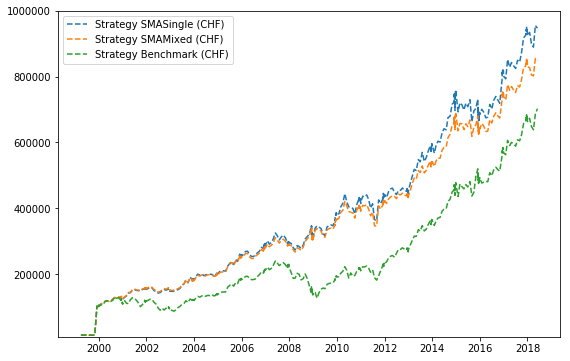

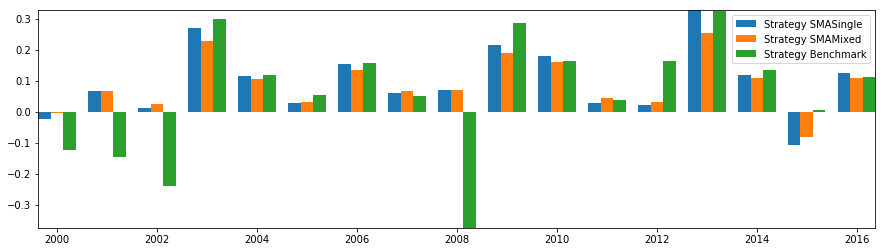

In [428]:
strats = [x[0] for x in results]  # flatten the result
plotwidth = 0.25
xreal = strats[0].datetime.plot()
xlen = len(xreal)
x = list(range(xlen))
ones = np.ones(xlen)

fmtdata = '%Y-%m-%d'
fig  = plt.figure(figsize=(9, 6))
fig2 = plt.figure(figsize=(15, 4))
ax   = fig.add_subplot(111)
ax2  = fig2.add_subplot(111)
fordata = fmt.MyDateFormatter(xreal, fmt=fmtdata)
ax.fmt_xdata = fordata
locmajor = loc.AutoDateLocator(xreal)
autofmt = loc.AutoDateFormatter(xreal, locmajor,defaultfmt=fmtdata)
plcolors = ['C0', 'C1', 'C2']
i=0
for strat in strats:
    broker = strat.observers.getbyname('broker')
    currencyadjuster = strat.observers.getbyname('portfoliocurrencyadjuster')
    cc = np.array(broker.lines[1].plot()) # Value in broker incl. cash
    ccc = np.array(currencyadjuster.lines[0].plot())
    (monidx, monthdates, ccmon) = MyUtils.ResampleDayToMonth(xreal,cc)
    (monidx, monthdates, cccmon) = MyUtils.ResampleDayToMonth(xreal,ccc)
    usdchf = strat.dnames['USDCHF'].close.plot() # Currency conversion
    startingvalue = cc[0]
    annret_dates, annret_returns = GetAnnualReturns(xreal,cc)
    #ax.plot(monidx, ccmon, plcolors[i], label="Strategy " + str(strat.stratname))
    ax.plot(monidx,cccmon, plcolors[i], linestyle="--", label="Strategy " + str(strat.stratname) + " (CHF)")
    ax2.bar(annret_dates[1:-1]+(i-1)*plotwidth,annret_returns[1:-1], width=plotwidth, label="Strategy " +str(strat.stratname))
    finalvalue = cc[-1]
    print(str(strat.stratname) + " final value: %.2f" % finalvalue)
    # Export the strategy
    datestr = np.array([datetime.date.fromordinal(int(dd)).isoformat() for dd in monthdates])
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))
    np.savetxt("OutputData/Strat_" + strat.stratname + ".csv", cols, delimiter=',', fmt='%s, %.2f, %.2f')
    i += 1
ax.xaxis.set_major_locator(locmajor)
ax.xaxis.set_major_formatter(autofmt)
#ax.set_yscale('log')
ax.legend()
ax.set_ylim([0.1E5, 1E6])
ax2.autoscale(tight=True)
ax2.legend()

In [239]:
(10*12+6)*1000

126000

/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site

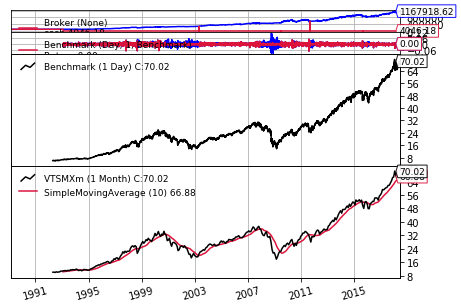

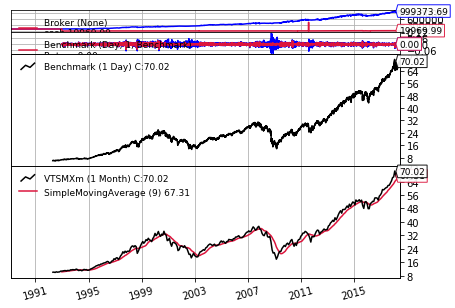

[[<Figure size 432x288 with 6 Axes>], [<Figure size 432x288 with 6 Axes>]]

In [146]:
reload(bt.plot.plot)
reload(bt.plot)
cerebro.plot()

In [382]:
import time
time.time()

1528884096.291384

In [399]:
bt.num2date(xreal[-1])

datetime.datetime(2018, 6, 8, 23, 59, 59, 999989)

In [392]:
a0.toordinal()

719171

In [395]:
xreal

array('d', [730122.9999999999, 730123.9999999999, 730124.9999999999, 730125.9999999999, 730126.9999999999, 730129.9999999999, 730130.9999999999, 730131.9999999999, 730132.9999999999, 730133.9999999999, 730137.9999999999, 730138.9999999999, 730139.9999999999, 730140.9999999999, 730143.9999999999, 730144.9999999999, 730145.9999999999, 730146.9999999999, 730147.9999999999, 730150.9999999999, 730151.9999999999, 730152.9999999999, 730153.9999999999, 730154.9999999999, 730157.9999999999, 730158.9999999999, 730159.9999999999, 730160.9999999999, 730161.9999999999, 730164.9999999999, 730165.9999999999, 730166.9999999999, 730167.9999999999, 730168.9999999999, 730172.9999999999, 730173.9999999999, 730174.9999999999, 730175.9999999999, 730178.9999999999, 730179.9999999999, 730180.9999999999, 730181.9999999999, 730182.9999999999, 730185.9999999999, 730186.9999999999, 730187.9999999999, 730188.9999999999, 730189.9999999999, 730192.9999999999, 730193.9999999999, 730194.9999999999, 730195.9999999999, 

In [249]:
fig = plt.figure()


plt.plot(bbb.keys(), np.cumsum(bbb.values())+1, label='bb')
plt.plot(bbb.keys(), np.cumsum(aaa.values())+1, label='aa')
plt.legend()

plt.show()


TypeError: unsupported operand type(s) for +: 'odict_values' and 'int'

<Figure size 432x288 with 0 Axes>

In [186]:
aac=np.cumsum(aa)+1

In [194]:
np.nanmax(aac)

1.9006355552280594

In [274]:
getattr?

TypeError: draw_wrapper() missing 1 required positional argument: 'renderer'

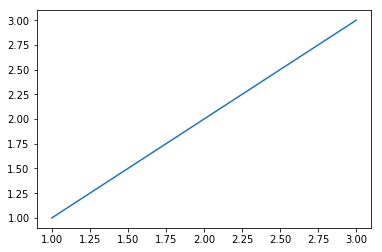

In [280]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,3,3),np.linspace(1,3,3))
